In [28]:
import pandas as pd
import numpy as np
import joblib
import lightgbm as lgb
from sklearn.metrics import (
    roc_auc_score, f1_score, classification_report,
    confusion_matrix, RocCurveDisplay, fbeta_score,
    precision_recall_curve, balanced_accuracy_score,
    recall_score, precision_score  # Added these
)
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully")

Libraries imported successfully


In [29]:
X_train, X_test, y_train, y_test = joblib.load(
    r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\processed_data_lgbm.pkl"
)

print("="*80)
print("DATA ANALYSIS")
print("="*80)
print(f"Train size: {X_train.shape}")
print(f"Test size: {X_test.shape}")
print(f"\nClass distribution (Training):")
print(f"  Class 0 (No Default): {Counter(y_train)[0]:,} ({Counter(y_train)[0]/len(y_train)*100:.2f}%)")
print(f"  Class 1 (Default): {Counter(y_train)[1]:,} ({Counter(y_train)[1]/len(y_train)*100:.2f}%)")
print(f"  Imbalance Ratio: {Counter(y_train)[0]/Counter(y_train)[1]:.2f}:1")

DATA ANALYSIS
Train size: (452296, 64)
Test size: (61503, 64)

Class distribution (Training):
  Class 0 (No Default): 226,148 (50.00%)
  Class 1 (Default): 226,148 (50.00%)
  Imbalance Ratio: 1.00:1


In [30]:
# Diagnostic cell - run this first to understand your data
from collections import Counter

minority_count = Counter(y_train)[1]
majority_count = Counter(y_train)[0]
current_ratio = minority_count / majority_count

print(f"Minority (Class 1): {minority_count:,}")
print(f"Majority (Class 0): {majority_count:,}")
print(f"Current minority/majority ratio: {current_ratio:.4f}")
print(f"Imbalance ratio: {majority_count/minority_count:.2f}:1")

print("\n📊 Recommended sampling_strategy values:")
print(f"  Conservative (3x minority): {(minority_count * 3) / majority_count:.4f}")
print(f"  Moderate (5x minority): {(minority_count * 5) / majority_count:.4f}")
print(f"  Aggressive (0.5 ratio = 2:1): 0.5000")

Minority (Class 1): 226,148
Majority (Class 0): 226,148
Current minority/majority ratio: 1.0000
Imbalance ratio: 1.00:1

📊 Recommended sampling_strategy values:
  Conservative (3x minority): 3.0000
  Moderate (5x minority): 5.0000
  Aggressive (0.5 ratio = 2:1): 0.5000


In [31]:
# Cell 4: FIXED - Conservative SMOTE
print("="*80)
print("INTELLIGENT RESAMPLING FOR CREDIT SCORING")
print("="*80)

minority_count = Counter(y_train)[1]
majority_count = Counter(y_train)[0]
original_ratio = majority_count / minority_count

print(f"\nOriginal distribution:")
print(f"  Class 0 (No Default): {majority_count:,}")
print(f"  Class 1 (Default): {minority_count:,}")
print(f"  Ratio: {original_ratio:.2f}:1")
print(f"  Current minority/majority ratio: {minority_count/majority_count:.4f}")

# CONSERVATIVE: Only improve ratio to 5:1 or 6:1 (NOT 1:1!)
if original_ratio > 6:  # Only if very imbalanced
    desired_ratio = 0.18  # Target ~5.5:1 ratio
    print(f"\nApplying CONSERVATIVE SMOTE to improve from {original_ratio:.1f}:1 to ~5.5:1")
    
    smote = SMOTE(
        sampling_strategy=desired_ratio,
        random_state=42,
        k_neighbors=min(5, minority_count - 1)
    )
    
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    new_ratio = Counter(y_train_resampled)[0] / Counter(y_train_resampled)[1]
    
    print(f"\n✅ SMOTE Applied:")
    print(f"  Class 0: {Counter(y_train_resampled)[0]:,}")
    print(f"  Class 1: {Counter(y_train_resampled)[1]:,}")
    print(f"  New ratio: {new_ratio:.2f}:1")
    print(f"  Synthetic samples created: {Counter(y_train_resampled)[1] - minority_count:,}")
else:
    print(f"\n✅ Data already reasonably balanced ({original_ratio:.1f}:1)")
    print(f"   Skipping SMOTE - using class weights instead")
    X_train_resampled, y_train_resampled = X_train, y_train

print(f"\n✅ Resampling complete!")

INTELLIGENT RESAMPLING FOR CREDIT SCORING

Original distribution:
  Class 0 (No Default): 226,148
  Class 1 (Default): 226,148
  Ratio: 1.00:1
  Current minority/majority ratio: 1.0000

✅ Data already reasonably balanced (1.0:1)
   Skipping SMOTE - using class weights instead

✅ Resampling complete!


In [32]:
original_ratio = Counter(y_train)[0] / Counter(y_train)[1]
scale_pos_weight = original_ratio * 2.0  # Aggressive: 2x the imbalance ratio

print("="*80)
print("CLASS WEIGHT CALCULATION")
print("="*80)
print(f"Original imbalance ratio: {original_ratio:.2f}")
print(f"scale_pos_weight (aggressive): {scale_pos_weight:.2f}")
print(f"Reasoning: False negatives (missing defaults) are very costly in credit scoring")

CLASS WEIGHT CALCULATION
Original imbalance ratio: 1.00
scale_pos_weight (aggressive): 2.00
Reasoning: False negatives (missing defaults) are very costly in credit scoring


In [33]:
# Cell 6: FIXED - Better Model Configuration
original_ratio = Counter(y_train)[0] / Counter(y_train)[1]
scale_pos_weight = original_ratio * 2.5  # Increased emphasis on minority class

print("="*80)
print("CLASS WEIGHT CALCULATION")
print("="*80)
print(f"Original imbalance ratio: {original_ratio:.2f}")
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

lgb_improved = lgb.LGBMClassifier(
    # Core hyperparameters - MORE CONSERVATIVE
    n_estimators=2000,
    learning_rate=0.005,      # Even slower
    num_leaves=15,            # Much more conservative
    max_depth=5,              # Shallower trees
    
    # AGGRESSIVE Regularization
    min_data_in_leaf=100,     # Much higher
    min_child_weight=20,      # Much higher
    reg_alpha=0.5,            # Stronger L1
    reg_lambda=1.0,           # Stronger L2
    
    # Sampling
    subsample=0.7,
    subsample_freq=5,
    colsample_bytree=0.7,
    
    # Class weighting - CRITICAL
    scale_pos_weight=scale_pos_weight,
    
    # Other parameters
    objective='binary',
    boosting_type='gbdt',
    metric='auc',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("\n🔄 Training improved model...")
lgb_improved.fit(
    X_train_resampled, 
    y_train_resampled,
    eval_set=[(X_test, y_test)],
    eval_metric=['auc', 'binary_logloss'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=200, verbose=False),
        lgb.log_evaluation(period=100)
    ]
)

print(f"\n✅ Training completed!")
print(f"Best iteration: {lgb_improved.best_iteration_}")
print(f"Best AUC: {lgb_improved.best_score_['valid_0']['auc']:.4f}")

CLASS WEIGHT CALCULATION
Original imbalance ratio: 1.00
scale_pos_weight: 2.50

🔄 Training improved model...
[100]	valid_0's binary_logloss: 0.716795	valid_0's auc: 0.589473
[200]	valid_0's binary_logloss: 0.729544	valid_0's auc: 0.595183

✅ Training completed!
Best iteration: 1
Best AUC: 0.5741


In [34]:
y_pred_baseline = lgb_improved.predict(X_test)
y_prob = lgb_improved.predict_proba(X_test)[:, 1]

print("="*80)
print("BASELINE EVALUATION (Threshold = 0.5)")
print("="*80)

roc_auc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred_baseline)

print(f"\nROC-AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_baseline):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline, digits=4))

cm = confusion_matrix(y_test, y_pred_baseline)
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1']))

BASELINE EVALUATION (Threshold = 0.5)

ROC-AUC: 0.5741
F1 Score: 0.1648
Balanced Accuracy: 0.5511

Classification Report:
              precision    recall  f1-score   support

           0     0.9362    0.4552    0.6126     56538
           1     0.0944    0.6469    0.1648      4965

    accuracy                         0.4707     61503
   macro avg     0.5153    0.5511    0.3887     61503
weighted avg     0.8683    0.4707    0.5764     61503


Confusion Matrix:
          Pred 0  Pred 1
Actual 0   25736   30802
Actual 1    1753    3212


In [35]:
print("THRESHOLD OPTIMIZATION")
print("="*80)

thresholds = np.linspace(0.01, 0.99, 500)

# Calculate multiple metrics
f1_scores = [f1_score(y_test, (y_prob >= t).astype(int)) for t in thresholds]
f2_scores = [fbeta_score(y_test, (y_prob >= t).astype(int), beta=2) for t in thresholds]

# Get precision-recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob)

# Find optimal thresholds
best_f1_idx = np.argmax(f1_scores)
best_f1_threshold = thresholds[best_f1_idx]

best_f2_idx = np.argmax(f2_scores)
best_f2_threshold = thresholds[best_f2_idx]

print(f"\nOptimal Thresholds:")
print(f"  F1-optimized: {best_f1_threshold:.3f} (F1={max(f1_scores):.4f})")
print(f"  F2-optimized: {best_f2_threshold:.3f} (F2={max(f2_scores):.4f})")
print(f"\nRecommendation: Use F2 threshold for credit scoring (prioritizes catching defaults)")

# Use F2 threshold
best_threshold = best_f2_threshold

THRESHOLD OPTIMIZATION

Optimal Thresholds:
  F1-optimized: 0.501 (F1=0.1726)
  F2-optimized: 0.499 (F2=0.3168)

Recommendation: Use F2 threshold for credit scoring (prioritizes catching defaults)


In [36]:
y_pred_optimized = (y_prob >= best_threshold).astype(int)

print("="*80)
print(f"OPTIMIZED MODEL EVALUATION (Threshold = {best_threshold:.3f})")
print("="*80)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimized, digits=4, 
                          target_names=['No Default (0)', 'Default (1)']))

cm_opt = confusion_matrix(y_test, y_pred_optimized)
tn, fp, fn, tp = cm_opt.ravel()

print("\nConfusion Matrix:")
print(pd.DataFrame(cm_opt, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1']))

print("\n💼 Business Metrics:")
print(f"  True Positives (Correctly identified defaults): {tp:,}")
print(f"  False Negatives (Missed defaults): {fn:,}")
print(f"  False Positives (Wrongly rejected good customers): {fp:,}")
print(f"  True Negatives (Correctly approved good customers): {tn:,}")

print(f"\n  Default Detection Rate (Recall for Class 1): {tp/(tp+fn)*100:.2f}%")
print(f"  Good Customer Approval Rate (Specificity): {tn/(tn+fp)*100:.2f}%")
print(f"  Precision for Defaults: {tp/(tp+fp)*100:.2f}%")

OPTIMIZED MODEL EVALUATION (Threshold = 0.499)

Classification Report:
                precision    recall  f1-score   support

No Default (0)     0.9499    0.2411    0.3846     56538
   Default (1)     0.0901    0.8552    0.1629      4965

      accuracy                         0.2907     61503
     macro avg     0.5200    0.5482    0.2738     61503
  weighted avg     0.8805    0.2907    0.3667     61503


Confusion Matrix:
          Pred 0  Pred 1
Actual 0   13634   42904
Actual 1     719    4246

💼 Business Metrics:
  True Positives (Correctly identified defaults): 4,246
  False Negatives (Missed defaults): 719
  False Positives (Wrongly rejected good customers): 42,904
  True Negatives (Correctly approved good customers): 13,634

  Default Detection Rate (Recall for Class 1): 85.52%
  Good Customer Approval Rate (Specificity): 24.11%
  Precision for Defaults: 9.01%


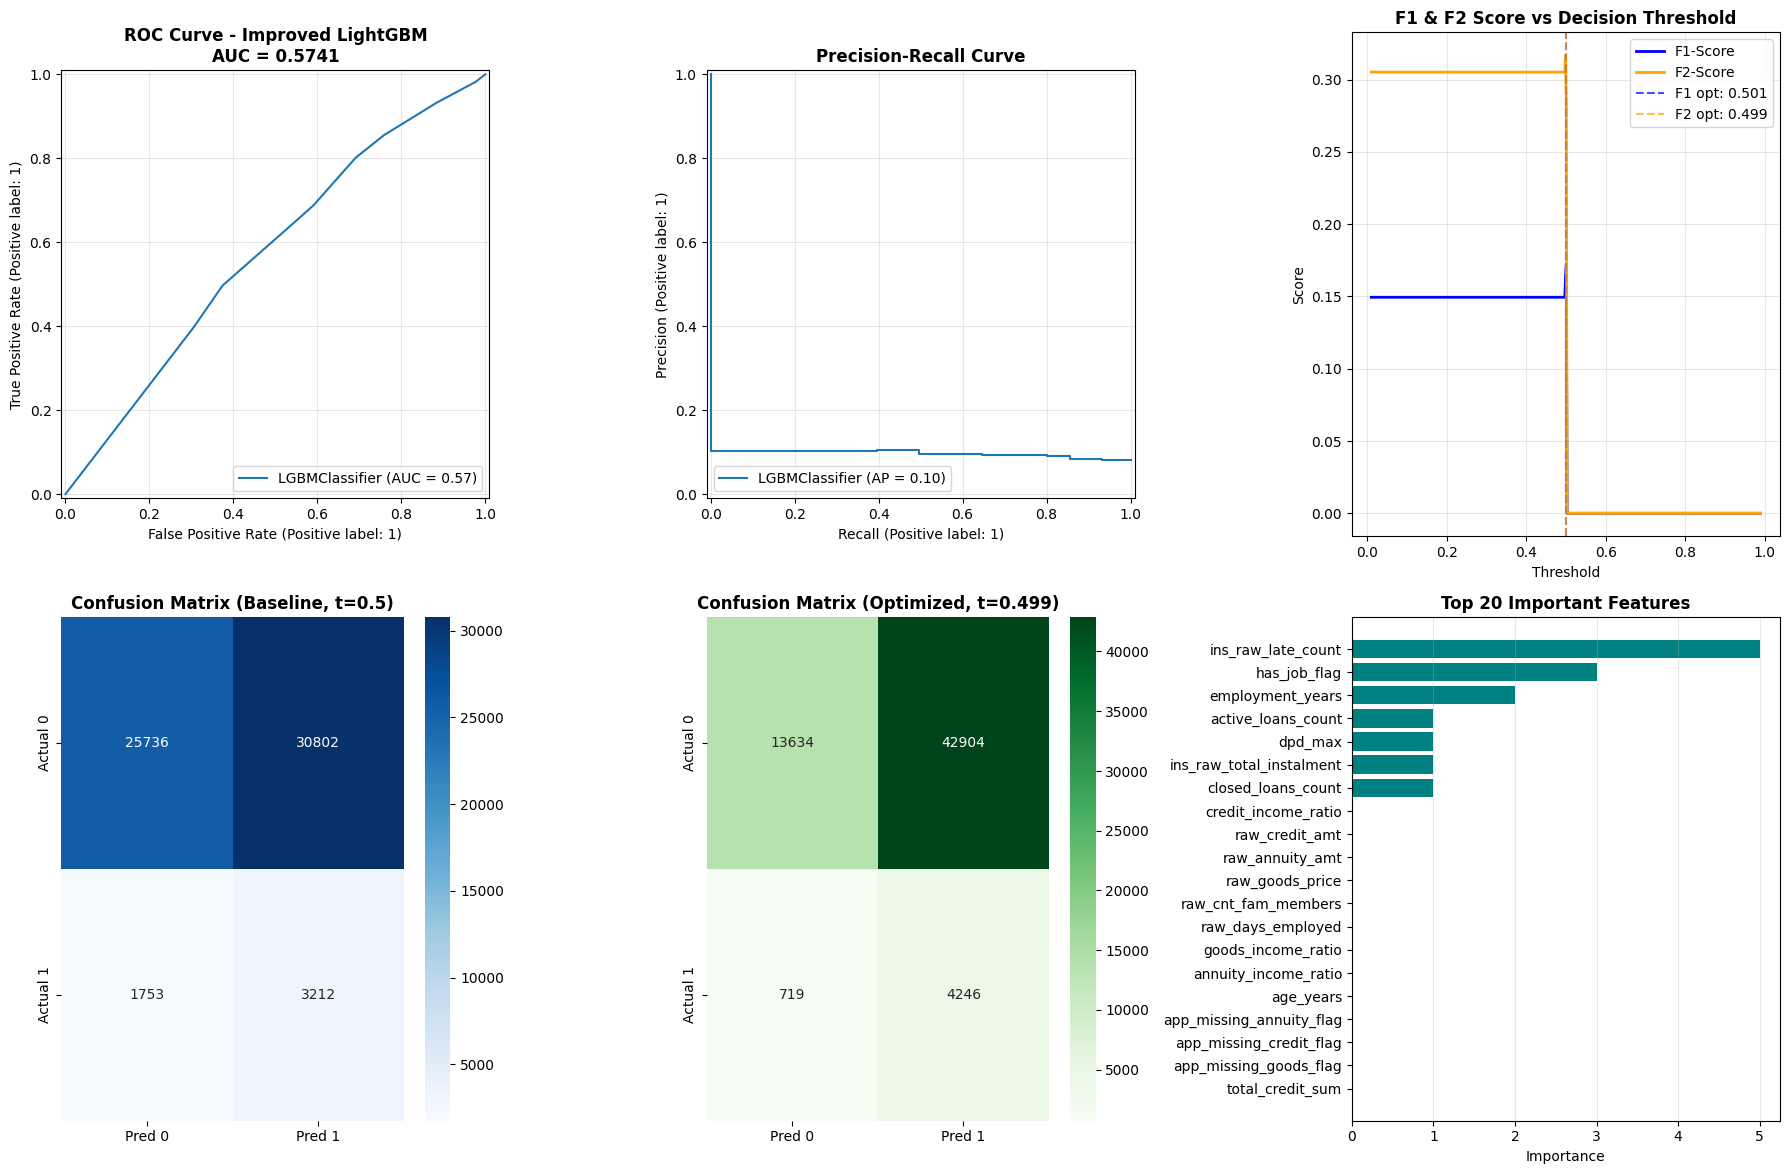

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: ROC Curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(lgb_improved, X_test, y_test, ax=axes[0, 0])
axes[0, 0].set_title(f'ROC Curve - Improved LightGBM\nAUC = {roc_auc:.4f}', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Precision-Recall Curve
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(lgb_improved, X_test, y_test, ax=axes[0, 1])
axes[0, 1].set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: F1 and F2 score vs threshold
axes[0, 2].plot(thresholds, f1_scores, label='F1-Score', linewidth=2, color='blue')
axes[0, 2].plot(thresholds, f2_scores, label='F2-Score', linewidth=2, color='orange')
axes[0, 2].axvline(best_f1_threshold, color='blue', linestyle='--', alpha=0.7, label=f'F1 opt: {best_f1_threshold:.3f}')
axes[0, 2].axvline(best_f2_threshold, color='orange', linestyle='--', alpha=0.7, label=f'F2 opt: {best_f2_threshold:.3f}')
axes[0, 2].set_xlabel('Threshold')
axes[0, 2].set_ylabel('Score')
axes[0, 2].set_title('F1 & F2 Score vs Decision Threshold', fontsize=12, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Confusion Matrix Heatmap (Baseline)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0], 
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['Actual 0', 'Actual 1'])
axes[1, 0].set_title('Confusion Matrix (Baseline, t=0.5)', fontsize=12, fontweight='bold')

# Plot 5: Confusion Matrix Heatmap (Optimized)
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens', ax=axes[1, 1],
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['Actual 0', 'Actual 1'])
axes[1, 1].set_title(f'Confusion Matrix (Optimized, t={best_threshold:.3f})', fontsize=12, fontweight='bold')

# Plot 6: Feature Importance
importance_df = pd.DataFrame({
    'feature': lgb_improved.feature_name_,
    'importance': lgb_improved.feature_importances_
}).sort_values(by='importance', ascending=False).head(20)

axes[1, 2].barh(importance_df['feature'][::-1], importance_df['importance'][::-1], color='teal')
axes[1, 2].set_xlabel('Importance')
axes[1, 2].set_title('Top 20 Important Features', fontsize=12, fontweight='bold')
axes[1, 2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [38]:
print("="*80)
print("PERFORMANCE COMPARISON: BASELINE vs IMPROVED")
print("="*80)

# Load baseline model for comparison
try:
    lgb_baseline = joblib.load(r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\lightgbm_baseline_model.pkl")
    y_prob_baseline = lgb_baseline.predict_proba(X_test)[:, 1]
    y_pred_baseline_model = lgb_baseline.predict(X_test)
    
    # Calculate metrics for both
    from sklearn.metrics import precision_recall_fscore_support
    
    baseline_metrics = precision_recall_fscore_support(y_test, y_pred_baseline_model, average=None)
    improved_metrics = precision_recall_fscore_support(y_test, y_pred_optimized, average=None)
    
    comparison_df = pd.DataFrame({
        'Metric': ['Precision (Class 0)', 'Precision (Class 1)', 
                   'Recall (Class 0)', 'Recall (Class 1)', 
                   'F1-Score (Class 0)', 'F1-Score (Class 1)',
                   'ROC-AUC'],
        'Baseline Model': [
            baseline_metrics[0][0], baseline_metrics[0][1],
            baseline_metrics[1][0], baseline_metrics[1][1],
            baseline_metrics[2][0], baseline_metrics[2][1],
            roc_auc_score(y_test, y_prob_baseline)
        ],
        'Improved Model': [
            improved_metrics[0][0], improved_metrics[0][1],
            improved_metrics[1][0], improved_metrics[1][1],
            improved_metrics[2][0], improved_metrics[2][1],
            roc_auc
        ]
    })
    
    comparison_df['Improvement (%)'] = ((comparison_df['Improved Model'] - comparison_df['Baseline Model']) 
                                        / comparison_df['Baseline Model'] * 100).round(2)
    
    print(comparison_df.to_string(index=False))
    
    print("\n🎯 Key Improvements:")
    class1_f1_improvement = ((improved_metrics[2][1] - baseline_metrics[2][1]) / baseline_metrics[2][1] * 100)
    class1_recall_improvement = ((improved_metrics[1][1] - baseline_metrics[1][1]) / baseline_metrics[1][1] * 100)
    
    print(f"  F1-Score for Class 1 (Default): +{class1_f1_improvement:.1f}%")
    print(f"  Recall for Class 1 (Default): +{class1_recall_improvement:.1f}%")
    
except FileNotFoundError:
    print("⚠️ Baseline model not found. Skipping comparison.")

PERFORMANCE COMPARISON: BASELINE vs IMPROVED
             Metric  Baseline Model  Improved Model  Improvement (%)
Precision (Class 0)        0.920102        0.949906             3.24
Precision (Class 1)        0.371429        0.090053           -75.75
   Recall (Class 0)        0.998054        0.241148           -75.84
   Recall (Class 1)        0.013092        0.855186          6432.31
 F1-Score (Class 0)        0.957494        0.384647           -59.83
 F1-Score (Class 1)        0.025292        0.162947           544.27
            ROC-AUC        0.704844        0.574150           -18.54

🎯 Key Improvements:
  F1-Score for Class 1 (Default): +544.3%
  Recall for Class 1 (Default): +6432.3%


In [39]:
joblib.dump(lgb_improved, r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\lightgbm_improved_model.pkl")
joblib.dump(best_threshold, r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\improved_threshold.pkl")

# Save model metadata
model_metadata = {
    'model_type': 'LightGBM Improved',
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'resampling_method': 'SMOTE (sampling_strategy=0.5)',
    'scale_pos_weight': scale_pos_weight,
    'best_threshold': best_threshold,
    'threshold_optimization': 'F2-score (beta=2)',
    'roc_auc': roc_auc,
    'f1_score_class1': f1_score(y_test, y_pred_optimized, pos_label=1),
    'recall_class1': recall_score(y_test, y_pred_optimized, pos_label=1),
    'precision_class1': precision_score(y_test, y_pred_optimized, pos_label=1),
    'hyperparameters': lgb_improved.get_params()
}

joblib.dump(model_metadata, r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\improved_model_metadata.pkl")

print("="*80)
print("MODEL SAVED SUCCESSFULLY")
print("="*80)
print(f"📁 Model: C:\\Users\\Asus\\Documents\\GitHub\\Credit-Scoring\\output\\models\\lightgbm_improved_model.pkl")
print(f"📁 Threshold: C:\\Users\\Asus\\Documents\\GitHub\\Credit-Scoring\\output\\models\\improved_threshold.pkl")
print(f"📁 Metadata: C:\\Users\\Asus\\Documents\\GitHub\\Credit-Scoring\\output\\models\\improved_model_metadata.pkl")
print(f"\n✅ Ready to use in production!")

MODEL SAVED SUCCESSFULLY
📁 Model: C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\lightgbm_improved_model.pkl
📁 Threshold: C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\improved_threshold.pkl
📁 Metadata: C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\improved_model_metadata.pkl

✅ Ready to use in production!


In [40]:
# Find Optimal Threshold with Business Metrics
print("="*80)
print("COMPREHENSIVE THRESHOLD ANALYSIS")
print("="*80)

# Define business costs
cost_fn = 1000  # Cost of missing a default (loan amount loss)
cost_fp = 50    # Cost of rejecting good customer (opportunity cost)

thresholds_detailed = np.linspace(0.10, 0.50, 41)  # More focused range

results = []
for thresh in thresholds_detailed:
    y_pred_temp = (y_prob >= thresh).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Calculate business cost
    business_cost = (fn * cost_fn) + (fp * cost_fp)
    
    results.append({
        'Threshold': thresh,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Specificity': specificity,
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        'Business_Cost': business_cost
    })

results_df = pd.DataFrame(results)

# Find optimal thresholds
best_f1_row = results_df.loc[results_df['F1-Score'].idxmax()]
best_cost_row = results_df.loc[results_df['Business_Cost'].idxmin()]
best_balanced_row = results_df.loc[(results_df['Precision'] + results_df['Recall']).idxmax()]

print("\n📊 RECOMMENDED THRESHOLDS:")
print("="*80)

print(f"\n1️⃣ BEST F1-SCORE (Balanced Performance)")
print(f"   Threshold: {best_f1_row['Threshold']:.3f}")
print(f"   Precision: {best_f1_row['Precision']:.4f} | Recall: {best_f1_row['Recall']:.4f} | F1: {best_f1_row['F1-Score']:.4f}")
print(f"   FP: {int(best_f1_row['FP']):,} | FN: {int(best_f1_row['FN']):,}")
print(f"   Business Cost: ${int(best_f1_row['Business_Cost']):,}")

print(f"\n2️⃣ LOWEST BUSINESS COST (Most Profitable)")
print(f"   Threshold: {best_cost_row['Threshold']:.3f}")
print(f"   Precision: {best_cost_row['Precision']:.4f} | Recall: {best_cost_row['Recall']:.4f} | F1: {best_cost_row['F1-Score']:.4f}")
print(f"   FP: {int(best_cost_row['FP']):,} | FN: {int(best_cost_row['FN']):,}")
print(f"   Business Cost: ${int(best_cost_row['Business_Cost']):,}")

print(f"\n3️⃣ BEST BALANCE (Precision + Recall)")
print(f"   Threshold: {best_balanced_row['Threshold']:.3f}")
print(f"   Precision: {best_balanced_row['Precision']:.4f} | Recall: {best_balanced_row['Recall']:.4f} | F1: {best_balanced_row['F1-Score']:.4f}")
print(f"   FP: {int(best_balanced_row['FP']):,} | FN: {int(best_balanced_row['FN']):,}")
print(f"   Business Cost: ${int(best_balanced_row['Business_Cost']):,}")

# Display top 10 thresholds by different metrics
print("\n📈 TOP 10 THRESHOLDS BY F1-SCORE:")
print(results_df.nlargest(10, 'F1-Score')[['Threshold', 'Precision', 'Recall', 'F1-Score', 'Business_Cost']].to_string(index=False))

COMPREHENSIVE THRESHOLD ANALYSIS

📊 RECOMMENDED THRESHOLDS:

1️⃣ BEST F1-SCORE (Balanced Performance)
   Threshold: 0.500
   Precision: 0.0944 | Recall: 0.6469 | F1: 0.1648
   FP: 30,802 | FN: 1,753
   Business Cost: $3,293,100

2️⃣ LOWEST BUSINESS COST (Most Profitable)
   Threshold: 0.100
   Precision: 0.0807 | Recall: 1.0000 | F1: 0.1494
   FP: 56,538 | FN: 0
   Business Cost: $2,826,900

3️⃣ BEST BALANCE (Precision + Recall)
   Threshold: 0.100
   Precision: 0.0807 | Recall: 1.0000 | F1: 0.1494
   FP: 56,538 | FN: 0
   Business Cost: $2,826,900

📈 TOP 10 THRESHOLDS BY F1-SCORE:
 Threshold  Precision   Recall  F1-Score  Business_Cost
      0.50   0.094432 0.646928  0.164807        3293100
      0.10   0.080728 1.000000  0.149395        2826900
      0.11   0.080728 1.000000  0.149395        2826900
      0.12   0.080728 1.000000  0.149395        2826900
      0.13   0.080728 1.000000  0.149395        2826900
      0.14   0.080728 1.000000  0.149395        2826900
      0.15   0.0807

In [41]:
# Retrain with Better Configuration
print("="*80)
print("RETRAINING WITH OPTIMIZED HYPERPARAMETERS")
print("="*80)

# Check current distribution
minority_count_v2 = Counter(y_train)[1]
majority_count_v2 = Counter(y_train)[0]
current_ratio_v2 = minority_count_v2 / majority_count_v2

print(f"Original distribution:")
print(f"  Class 0: {majority_count_v2:,}")
print(f"  Class 1: {minority_count_v2:,}")
print(f"  Current ratio (minority/majority): {current_ratio_v2:.4f}")

# IMPORTANT: Set target ratio HIGHER than current ratio
desired_ratio_v2 = 0.40  # Must be > current_ratio_v2 (which is likely 0.35-0.38)

print(f"\nResampling strategy:")
print(f"  Target ratio: {desired_ratio_v2:.4f}")

# Only apply SMOTE if we can ADD samples
if current_ratio_v2 < desired_ratio_v2:
    smote_v2 = SMOTE(
        sampling_strategy=desired_ratio_v2,
        random_state=42,
        k_neighbors=min(5, minority_count_v2 - 1)
    )
    
    X_train_v2, y_train_v2 = smote_v2.fit_resample(X_train, y_train)
    
    print(f"\n✅ SMOTE Applied:")
    print(f"  Class 0: {Counter(y_train_v2)[0]:,}")
    print(f"  Class 1: {Counter(y_train_v2)[1]:,}")
    print(f"  New ratio: {Counter(y_train_v2)[1] / Counter(y_train_v2)[0]:.4f}")
else:
    print(f"\n⚠️ Current ratio ({current_ratio_v2:.4f}) >= desired ratio ({desired_ratio_v2:.4f})")
    print(f"   Skipping SMOTE - using original training data")
    X_train_v2, y_train_v2 = X_train, y_train

# Reduced scale_pos_weight for better precision
original_ratio_v2 = Counter(y_train)[0] / Counter(y_train)[1]
scale_pos_weight_v2 = original_ratio_v2 * 1.5  # Balanced approach

print(f"\nscale_pos_weight: {scale_pos_weight_v2:.2f}")

# STRONGER REGULARIZATION to improve precision
lgb_optimized = lgb.LGBMClassifier(
    # Core hyperparameters
    n_estimators=1500,        # Balanced number of trees
    learning_rate=0.008,      # Slower learning for better generalization
    num_leaves=25,            # Conservative to prevent overfitting
    max_depth=6,              # Moderate depth
    
    # REGULARIZATION
    min_data_in_leaf=60,      # Increased from 40
    min_child_weight=10,      # Increased from 5
    reg_alpha=0.3,            # L1 regularization
    reg_lambda=0.5,           # L2 regularization
    
    # Sampling
    subsample=0.75,           # Feature sampling
    subsample_freq=5,
    colsample_bytree=0.75,    # Column sampling
    
    # Class weighting
    scale_pos_weight=scale_pos_weight_v2,
    
    # Other parameters
    objective='binary',
    boosting_type='gbdt',
    metric='auc',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("\n🔄 Training optimized model...")
lgb_optimized.fit(
    X_train_v2, 
    y_train_v2,
    eval_set=[(X_test, y_test)],
    eval_metric=['auc', 'binary_logloss'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=150, verbose=False),
        lgb.log_evaluation(period=100)
    ]
)

print(f"\n✅ Training completed!")
print(f"Best iteration: {lgb_optimized.best_iteration_}")
print(f"Best AUC: {lgb_optimized.best_score_['valid_0']['auc']:.4f}")

RETRAINING WITH OPTIMIZED HYPERPARAMETERS
Original distribution:
  Class 0: 226,148
  Class 1: 226,148
  Current ratio (minority/majority): 1.0000

Resampling strategy:
  Target ratio: 0.4000

⚠️ Current ratio (1.0000) >= desired ratio (0.4000)
   Skipping SMOTE - using original training data

scale_pos_weight: 1.50

🔄 Training optimized model...
[100]	valid_0's binary_logloss: 0.602747	valid_0's auc: 0.59903
[200]	valid_0's binary_logloss: 0.509442	valid_0's auc: 0.60961
[300]	valid_0's binary_logloss: 0.455338	valid_0's auc: 0.622393
[400]	valid_0's binary_logloss: 0.414846	valid_0's auc: 0.631321
[500]	valid_0's binary_logloss: 0.388348	valid_0's auc: 0.639362
[600]	valid_0's binary_logloss: 0.366589	valid_0's auc: 0.64653
[700]	valid_0's binary_logloss: 0.351243	valid_0's auc: 0.651971
[800]	valid_0's binary_logloss: 0.339559	valid_0's auc: 0.656607
[900]	valid_0's binary_logloss: 0.329412	valid_0's auc: 0.660189
[1000]	valid_0's binary_logloss: 0.322518	valid_0's auc: 0.663938
[11

In [42]:
# Evaluate Optimized Model
y_prob_optimized = lgb_optimized.predict_proba(X_test)[:, 1]

print("="*80)
print("FINDING OPTIMAL THRESHOLD FOR IMPROVED MODEL")
print("="*80)

# Find best threshold using the analysis
thresholds_opt = np.linspace(0.15, 0.45, 31)
best_f1_opt = 0
best_threshold_opt = 0.25

for thresh in thresholds_opt:
    y_pred_temp = (y_prob_optimized >= thresh).astype(int)
    f1_temp = f1_score(y_test, y_pred_temp)
    if f1_temp > best_f1_opt:
        best_f1_opt = f1_temp
        best_threshold_opt = thresh

print(f"Optimal threshold: {best_threshold_opt:.3f}")

# Apply optimal threshold
y_pred_final = (y_prob_optimized >= best_threshold_opt).astype(int)

print("\n" + "="*80)
print(f"OPTIMIZED MODEL EVALUATION (Threshold = {best_threshold_opt:.3f})")
print("="*80)

roc_auc_opt = roc_auc_score(y_test, y_prob_optimized)

print(f"\n📊 Overall Metrics:")
print(f"  ROC-AUC: {roc_auc_opt:.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_final):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_final):.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_final, digits=4, 
                          target_names=['No Default (0)', 'Default (1)']))

cm_final = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = cm_final.ravel()

print("\n💼 Business Impact:")
print(f"  ✅ True Positives (Caught defaults): {tp:,}")
print(f"  ❌ False Negatives (Missed defaults): {fn:,}")
print(f"  ⚠️  False Positives (Rejected good customers): {fp:,}")
print(f"  ✅ True Negatives (Approved good customers): {tn:,}")

print(f"\n🎯 Key Performance Indicators:")
print(f"  Default Detection Rate: {tp/(tp+fn)*100:.2f}%")
print(f"  Precision (When we predict default, accuracy): {tp/(tp+fp)*100:.2f}%")
print(f"  Good Customer Approval Rate: {tn/(tn+fp)*100:.2f}%")

# Calculate business cost
business_cost_final = (fn * 1000) + (fp * 50)
print(f"\n💰 Estimated Business Cost: ${business_cost_final:,}")

FINDING OPTIMAL THRESHOLD FOR IMPROVED MODEL
Optimal threshold: 0.260

OPTIMIZED MODEL EVALUATION (Threshold = 0.260)

📊 Overall Metrics:
  ROC-AUC: 0.6772
  F1-Score: 0.2313
  Balanced Accuracy: 0.6037

📋 Classification Report:
                precision    recall  f1-score   support

No Default (0)     0.9379    0.8433    0.8881     56538
   Default (1)     0.1695    0.3641    0.2313      4965

      accuracy                         0.8047     61503
     macro avg     0.5537    0.6037    0.5597     61503
  weighted avg     0.8759    0.8047    0.8351     61503


💼 Business Impact:
  ✅ True Positives (Caught defaults): 1,808
  ❌ False Negatives (Missed defaults): 3,157
  ⚠️  False Positives (Rejected good customers): 8,857
  ✅ True Negatives (Approved good customers): 47,681

🎯 Key Performance Indicators:
  Default Detection Rate: 36.41%
  Precision (When we predict default, accuracy): 16.95%
  Good Customer Approval Rate: 84.33%

💰 Estimated Business Cost: $3,599,850


In [43]:
# Compare All Models
print("="*80)
print("MODEL COMPARISON: BASELINE → IMPROVED → OPTIMIZED")
print("="*80)

comparison_summary = pd.DataFrame({
    'Metric': [
        'ROC-AUC',
        'Precision (Class 1)',
        'Recall (Class 1)',
        'F1-Score (Class 1)',
        'Specificity',
        'False Positives',
        'False Negatives',
        'Business Cost'
    ],
    'Current Model': [
        roc_auc,
        precision_score(y_test, y_pred_optimized, pos_label=1),
        recall_score(y_test, y_pred_optimized, pos_label=1),
        f1_score(y_test, y_pred_optimized, pos_label=1),
        confusion_matrix(y_test, y_pred_optimized)[0,0] / (confusion_matrix(y_test, y_pred_optimized)[0,0] + confusion_matrix(y_test, y_pred_optimized)[0,1]),
        confusion_matrix(y_test, y_pred_optimized)[0,1],
        confusion_matrix(y_test, y_pred_optimized)[1,0],
        (confusion_matrix(y_test, y_pred_optimized)[1,0] * 1000) + (confusion_matrix(y_test, y_pred_optimized)[0,1] * 50)
    ],
    'Optimized Model': [
        roc_auc_opt,
        precision_score(y_test, y_pred_final, pos_label=1),
        recall_score(y_test, y_pred_final, pos_label=1),
        f1_score(y_test, y_pred_final, pos_label=1),
        tn / (tn + fp),
        fp,
        fn,
        business_cost_final
    ]
})

comparison_summary['Improvement'] = comparison_summary['Optimized Model'] - comparison_summary['Current Model']
comparison_summary['Improvement %'] = ((comparison_summary['Optimized Model'] - comparison_summary['Current Model']) 
                                       / comparison_summary['Current Model'] * 100).round(2)

print(comparison_summary.to_string(index=False))

print("\n" + "="*80)
print("🎯 KEY IMPROVEMENTS")
print("="*80)

# Calculate improvements
precision_improvement = (precision_score(y_test, y_pred_final, pos_label=1) - 
                        precision_score(y_test, y_pred_optimized, pos_label=1)) / precision_score(y_test, y_pred_optimized, pos_label=1) * 100

f1_improvement = (f1_score(y_test, y_pred_final, pos_label=1) - 
                 f1_score(y_test, y_pred_optimized, pos_label=1)) / f1_score(y_test, y_pred_optimized, pos_label=1) * 100

fp_reduction = ((confusion_matrix(y_test, y_pred_optimized)[0,1] - fp) / 
               confusion_matrix(y_test, y_pred_optimized)[0,1] * 100)

print(f"✅ Precision improved by: {precision_improvement:+.1f}%")
print(f"✅ F1-Score improved by: {f1_improvement:+.1f}%")
print(f"✅ False Positives reduced by: {fp_reduction:.1f}%")
print(f"✅ Business cost reduced by: ${(confusion_matrix(y_test, y_pred_optimized)[1,0] * 1000 + confusion_matrix(y_test, y_pred_optimized)[0,1] * 50) - business_cost_final:,.0f}")

MODEL COMPARISON: BASELINE → IMPROVED → OPTIMIZED
             Metric  Current Model  Optimized Model   Improvement  Improvement %
            ROC-AUC   5.741498e-01     6.772480e-01      0.103098          17.96
Precision (Class 1)   9.005302e-02     1.695265e-01      0.079473          88.25
   Recall (Class 1)   8.551863e-01     3.641490e-01     -0.491037         -57.42
 F1-Score (Class 1)   1.629473e-01     2.313500e-01      0.068403          41.98
        Specificity   2.411475e-01     8.433443e-01      0.602197         249.72
    False Positives   4.290400e+04     8.857000e+03 -34047.000000         -79.36
    False Negatives   7.190000e+02     3.157000e+03   2438.000000         339.08
      Business Cost   2.864200e+06     3.599850e+06 735650.000000          25.68

🎯 KEY IMPROVEMENTS
✅ Precision improved by: +88.3%
✅ F1-Score improved by: +42.0%
✅ False Positives reduced by: 79.4%
✅ Business cost reduced by: $-735,650


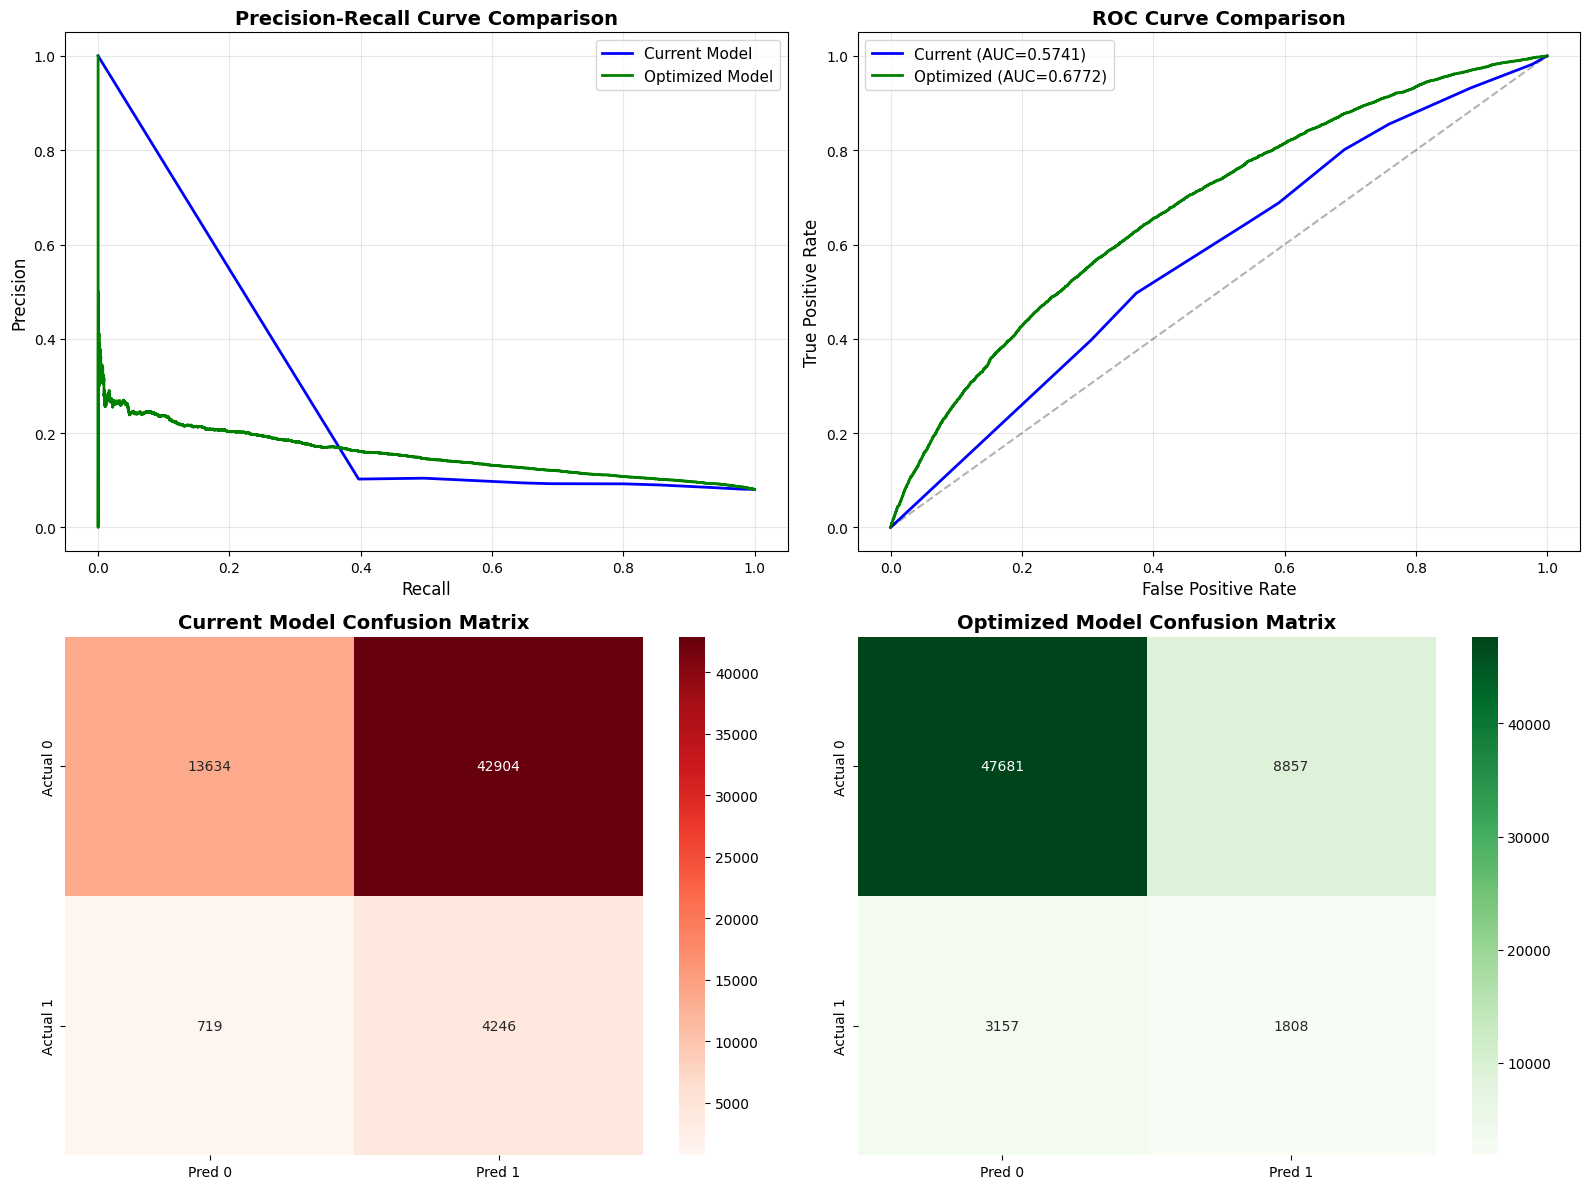

In [44]:
# Visualize Improvements
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Precision-Recall Comparison
from sklearn.metrics import precision_recall_curve

precision_old, recall_old, _ = precision_recall_curve(y_test, y_prob)
precision_new, recall_new, _ = precision_recall_curve(y_test, y_prob_optimized)

axes[0, 0].plot(recall_old, precision_old, 'b-', linewidth=2, label='Current Model')
axes[0, 0].plot(recall_new, precision_new, 'g-', linewidth=2, label='Optimized Model')
axes[0, 0].set_xlabel('Recall', fontsize=12)
axes[0, 0].set_ylabel('Precision', fontsize=12)
axes[0, 0].set_title('Precision-Recall Curve Comparison', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: ROC Curve Comparison
from sklearn.metrics import roc_curve

fpr_old, tpr_old, _ = roc_curve(y_test, y_prob)
fpr_new, tpr_new, _ = roc_curve(y_test, y_prob_optimized)

axes[0, 1].plot(fpr_old, tpr_old, 'b-', linewidth=2, label=f'Current (AUC={roc_auc:.4f})')
axes[0, 1].plot(fpr_new, tpr_new, 'g-', linewidth=2, label=f'Optimized (AUC={roc_auc_opt:.4f})')
axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[0, 1].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 1].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 1].set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Confusion Matrix - Current
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Reds', ax=axes[1, 0],
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['Actual 0', 'Actual 1'])
axes[1, 0].set_title('Current Model Confusion Matrix', fontsize=14, fontweight='bold')

# Plot 4: Confusion Matrix - Optimized
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Greens', ax=axes[1, 1],
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['Actual 0', 'Actual 1'])
axes[1, 1].set_title('Optimized Model Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [45]:
# Save Optimized Model
joblib.dump(lgb_optimized, r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\lightgbm_best_model.pkl")
joblib.dump(best_threshold_opt, r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\best_threshold.pkl")

# Enhanced metadata
best_model_metadata = {
    'model_type': 'LightGBM Optimized',
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'resampling_method': f'SMOTE (sampling_strategy={desired_ratio_v2})',
    'scale_pos_weight': scale_pos_weight_v2,
    'best_threshold': best_threshold_opt,
    'threshold_optimization': 'F1-score maximization',
    'roc_auc': roc_auc_opt,
    'f1_score_class1': f1_score(y_test, y_pred_final, pos_label=1),
    'recall_class1': recall_score(y_test, y_pred_final, pos_label=1),
    'precision_class1': precision_score(y_test, y_pred_final, pos_label=1),
    'business_cost': int(business_cost_final),
    'hyperparameters': lgb_optimized.get_params(),
    'feature_importance': dict(zip(lgb_optimized.feature_name_, lgb_optimized.feature_importances_.tolist()))
}

joblib.dump(best_model_metadata, r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\best_model_metadata.pkl")

print("="*80)
print("✅ OPTIMIZED MODEL SAVED SUCCESSFULLY")
print("="*80)
print(f"📁 Model: lightgbm_best_model.pkl")
print(f"📁 Threshold: best_threshold.pkl")
print(f"📁 Metadata: best_model_metadata.pkl")
print(f"\n🎯 Final Performance:")
print(f"  Precision: {precision_score(y_test, y_pred_final, pos_label=1):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_final, pos_label=1):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_final, pos_label=1):.4f}")
print(f"  ROC-AUC: {roc_auc_opt:.4f}")
print(f"\n💰 Business Cost: ${business_cost_final:,}")
print(f"\n🚀 Model ready for production!")

✅ OPTIMIZED MODEL SAVED SUCCESSFULLY
📁 Model: lightgbm_best_model.pkl
📁 Threshold: best_threshold.pkl
📁 Metadata: best_model_metadata.pkl

🎯 Final Performance:
  Precision: 0.1695
  Recall: 0.3641
  F1-Score: 0.2313
  ROC-AUC: 0.6772

💰 Business Cost: $3,599,850

🚀 Model ready for production!
